# Test earth Sampling

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ee
from tqdm import tqdm
from mangroves.collection import Collection
from mangroves.utils import haversine, geodesic_circle
from mangroves.constants import BANDS

with open('/Users/galex/Desktop/gee_project_key.txt', "r") as f:
    project = f.readline().strip()

collection = Collection(project=project)

2025-11-21 15:14:31,526 - INFO - Google Earth Engine initialized successfully with service account


### Inputs

In [ ]:
nPixels = 244
lat0_deg = 1.41150
lon0_deg = 103.9569
year = 2018

### Reference Point

In [3]:
pt0 = ee.Geometry.Point([lon0_deg, lat0_deg], proj='EPSG:4326')
img0 = ee.Image(ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
               .filterDate(f'{year}-01-01', f'{year+1}-01-01')
               .filterBounds(pt0)
               .first())
pixel_data = img0.select(BANDS).sample(pt0)
values0 = np.array(list(pixel_data.getInfo()['features'][0]['properties'].values()))

### Surronding Points

  0%|          | 0/441 [00:00<?, ?it/s]

100%|██████████| 441/441 [02:58<00:00,  2.48it/s]


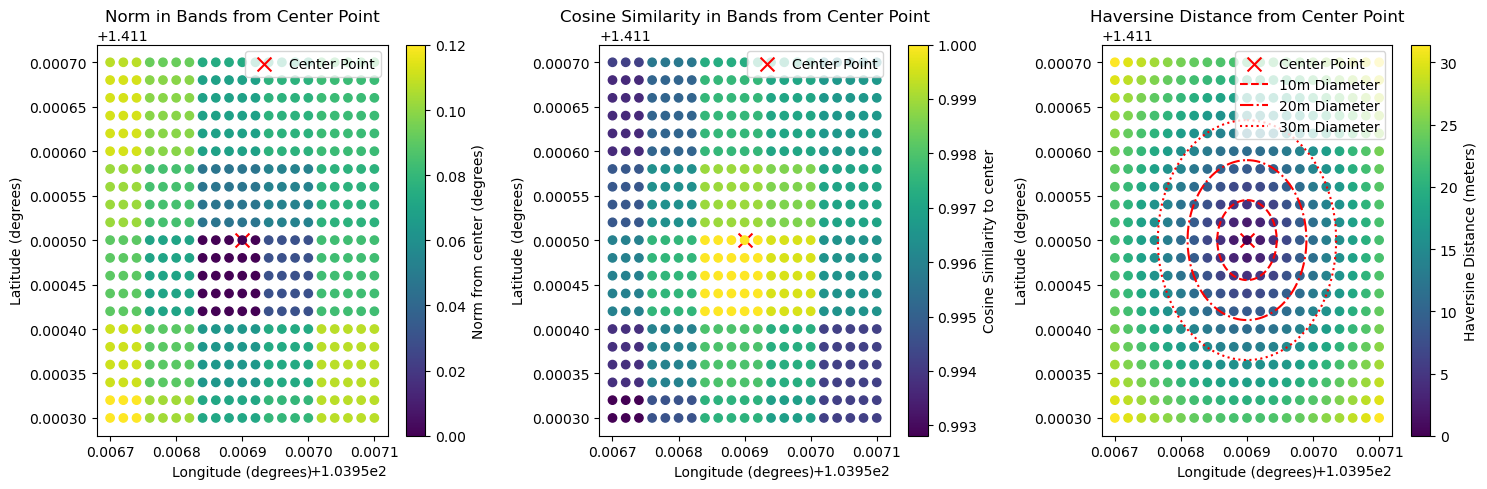

In [4]:
lon_min_deg = 0.0002
lon_max_deg = lat_min_deg = lat_max_deg = lon_min_deg
step = lon_min_deg / 10

dlat_deg_array = np.arange(-lat_min_deg, lat_max_deg + step, step)
dlon_deg_array = np.arange(-lon_min_deg, lon_max_deg + step, step)

output = []
progress_bar = tqdm(total=len(dlat_deg_array) * len(dlon_deg_array))
for dlat_deg in dlat_deg_array:
    for dlon_lag in dlon_deg_array:
        lat_deg = lat0_deg + dlat_deg
        lon_deg = lon0_deg + dlon_lag  

        pt = ee.Geometry.Point([lon_deg, lat_deg], proj='EPSG:4326')
        img = ee.Image(ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
                    .filterDate(f'{year}-01-01', f'{year+1}-01-01')
                    .filterBounds(pt)
                    .first())
        
        pixel_data = img.select(BANDS).sample(pt)
        values = np.array(list(pixel_data.getInfo()['features'][0]['properties'].values()))

        output.append(
            {
                'lat_deg': lat_deg,
                'lon_deg': lon_deg,
                'A': values,
                'norm': np.linalg.norm(values - values0),
                'cosine_sim': np.dot(values, values0) / (np.linalg.norm(values) * np.linalg.norm(values0)),
                'haversine_m': haversine(lat0_deg, lat_deg, lon0_deg, lon_deg),
            }
        )
        progress_bar.update(1)
progress_bar.close()


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter([lon0_deg], [lat0_deg], color='red', marker='x', s=100, label='Center Point')
plt.scatter(
    [r['lon_deg'] for r in output],
    [r['lat_deg'] for r in output],
    c=[r['norm'] for r in output],
    cmap='viridis',
)
plt.colorbar(label='Norm from center (degrees)')
plt.legend()
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Norm in Bands from Center Point')

plt.subplot(1, 3, 2)
plt.scatter([lon0_deg], [lat0_deg], color='red', marker='x', s=100, label='Center Point')
plt.scatter(
    [r['lon_deg'] for r in output],
    [r['lat_deg'] for r in output],
    c=[r['cosine_sim'] for r in output],
    cmap='viridis',
)
plt.colorbar(label='Cosine Similarity to center')
plt.legend()
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Cosine Similarity in Bands from Center Point')

plt.subplot(1, 3, 3)
plt.scatter([lon0_deg], [lat0_deg], color='red', marker='x', s=100, label='Center Point')
circle_10m_pts = geodesic_circle(lat0_deg, lon0_deg, 10. / 2.)
circle_10m_lats, circle_10m_lons = zip(*circle_10m_pts)
circle_20m_pts = geodesic_circle(lat0_deg, lon0_deg, 20. / 2.)
circle_20m_lats, circle_20m_lons = zip(*circle_20m_pts)
circle_30m_pts = geodesic_circle(lat0_deg, lon0_deg, 30. / 2.)
circle_30m_lats, circle_30m_lons = zip(*circle_30m_pts)
plt.plot(circle_10m_lons, circle_10m_lats, color='red', linestyle='--', label='10m Diameter')
plt.plot(circle_20m_lons, circle_20m_lats, color='red', linestyle='-.', label='20m Diameter')
plt.plot(circle_30m_lons, circle_30m_lats, color='red', linestyle=':', label='30m Diameter')
plt.scatter(
    [r['lon_deg'] for r in output],
    [r['lat_deg'] for r in output],
    c=[r['haversine_m'] for r in output],
    cmap='viridis',
)
plt.colorbar(label='Haversine Distance (meters)')
plt.legend()
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Haversine Distance from Center Point')

plt.tight_layout()
# plt.savefig('earth_sampling.png', dpi=300)

In [5]:
scale = ee.Number(img.select(BANDS).projection().nominalScale())  # pixel size in CRS units
scale.getInfo()

10